In [4]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
import os
import random
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torchsummary import summary
import numpy as np

In [5]:
seed = 17
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
df = pd.read_csv("/home/young/chanyoung/Experiment/polyp_segmentation/csv/kvasir_seg.csv")
train_df, test_df, _, _ = train_test_split(df, df['mask'].values, test_size=0.1, random_state=seed)
test_df = test_df[:4]
S = nn.Sigmoid()

In [6]:
for path in test_df['image']:
    print(path)

/home/young/chanyoung/Experiment/dataset/kvasir-seg/Kvasir-SEG/images/cju8aeei7q8k308173n9y4klv.jpg
/home/young/chanyoung/Experiment/dataset/kvasir-seg/Kvasir-SEG/images/cju7fen322ou10817ziqkob4k.jpg
/home/young/chanyoung/Experiment/dataset/kvasir-seg/Kvasir-SEG/images/cju7awzmu1ncs0871hziy65zx.jpg
/home/young/chanyoung/Experiment/dataset/kvasir-seg/Kvasir-SEG/images/cju18849rrsgr0988p90hkygb.jpg


In [7]:
color_map = {
    0:(0,0,0),
    1:(255,0,0),
}

def prediction_to_vis(prediction):
    vis_shape = prediction.shape + (3,)
    vis = np.zeros(vis_shape)
    for i,c in color_map.items():
        vis[prediction == i] = color_map[i]
    return Image.fromarray(vis.astype(np.uint8))

/home/young/miniconda3/envs/young/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


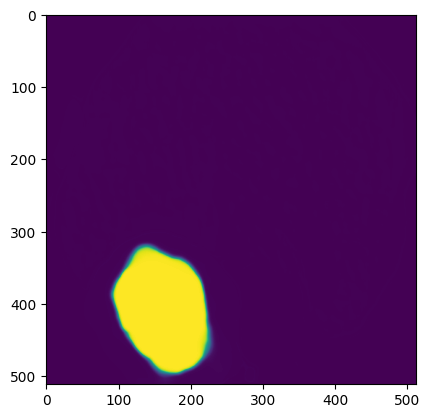

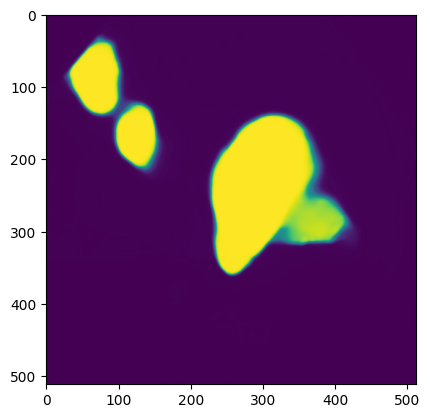

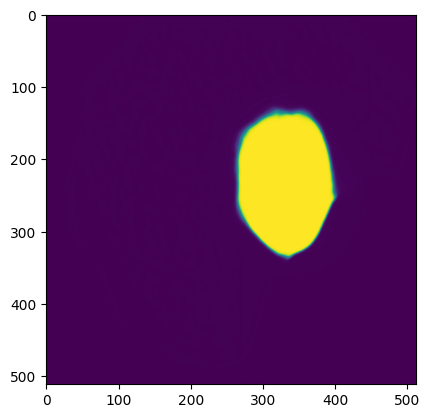

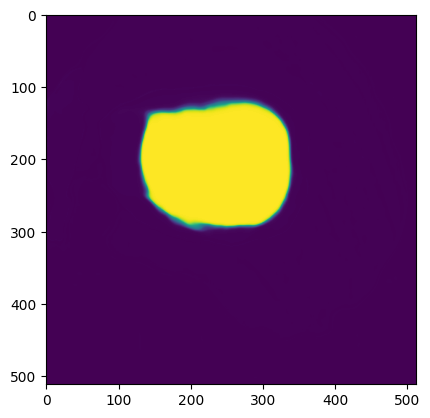

In [8]:
from dataset.segmentationDataset import SegmentationDataset
from model.tecdv2 import TECDv2

feature_extractor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512")
test_dataset = SegmentationDataset(test_df['image'].values, test_df['mask'].values, img_size=512,
                                      transforms=None, feature_extractor=feature_extractor)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False, num_workers=0)
model = TECDv2()

path = "/home/young/chanyoung/Trainer/_RESULT/polyp_segmentation/TECDv2.pt"
try:
    model.load_state_dict(torch.load(path))
except:
    state_dict = torch.load(path)
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

model.to(device)
model.eval()

mIOU = []
dCOF = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)    
        outputs = model(images)
        outputs = S(outputs)
        
        labels = labels.detach().squeeze().cpu().numpy()
        outputs = outputs.detach().squeeze().cpu().numpy()
        # outputs = (outputs > 0.5) * 1.0
        
        from matplotlib import pyplot as plt
        # plt.imshow(labels)
        # plt.show()
        plt.imshow(outputs)
        plt.show() 
        